In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
import tensorflow.keras.utils
from tensorflow.keras.utils import multi_gpu_model
import pandas as pd

from datetime import datetime
from packaging import version

print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] < 2, \
    "This notebook does not worl for TensorFlow 2.0"

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import math
import time
import h5py
import sklearn
from sklearn.utils import shuffle
from tensorflow.keras import *

import os
# from numba import jit

TensorFlow version:  1.13.1


# Loading Data for CNN

In [3]:
train_data = np.load("./NormedShowJet_addgrommedtau_train.npz")
test_data = np.load("./NormedShowJet_addgrommedtau_test.npz")
print(train_data.files)

['jetImages', 'jetPt', 'jetEta', 'jetPhi', 'tau21', 'tau31', 'tau32', 'tau21_sd', 'tau31_sd', 'tau32_sd', 'chMult', 'neutMult', 'phoMult', 'eleMult', 'muMult', 'jetpull', 'labels']


# Image Only CNN

In [ ]:
def build_model():
    input1 = layers.Input(shape = (16, 16,1))
#     x = layers.Conv2D(32, (5, 5), activation='relu', padding='same', name = 'conv1')(input1)
#     x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name = 'conv2')(x)
#     x = layers.MaxPool2D((2, 2), name = 'maxpool2x2_1')(x)
#     x = layers.Conv2D(64, (5, 5), activation='relu', padding='same', name = 'conv3')(x)
#     x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name = 'conv4')(x)
#     x = layers.MaxPool2D((2, 2), name = 'maxpool2x2_2')(x)
#     x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name = 'conv5')(x)
#     x = layers.Conv2D(16, (2, 2), activation='relu', padding='same', name = 'conv6')(x)
#     x = layers.MaxPool2D((2, 2), name = 'maxpool2x2_3')(x)

    x = layers.Conv2D(32, (5, 5), activation='relu', padding='same', name = 'conv1')(input1)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name = 'conv2')(x)
#     x = layers.Conv2D(256, (2, 2), activation='relu', padding='same', name = 'conv3')(x)
    x = layers.MaxPool2D((2, 2), name = 'maxpool2x2_1')(x)
    x = layers.Flatten(name = 'flatten')(x)
    x = layers.Dense(256, activation='relu', name = 'relu1')(x)
#     x = layers.Dense(512, activation='relu', name = 'relu2')(x)    
    output = layers.Dense(2, activation='softmax', name = 'softmax')(x)
    model = models.Model(inputs=input1, outputs=output)
    
    opt=keras.optimizers.Adam(lr=0.001,beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(loss='binary_crossentropy',
                optimizer=opt,
                metrics=['binary_crossentropy', 'accuracy'])
    return model

In [ ]:
ImageonlyCNN = build_model()

In [ ]:
X_batch = train_data['jetImages'][:10]
Y_batch = train_data['labels'][:10]
example_result = ImageonlyCNN.predict(x = X_batch)
results = ImageonlyCNN.evaluate(x = X_batch, y =Y_batch )
print(example_result)
print(results)

In [ ]:
checkpoint_path = "model/CNN_imageonly_addgroomedtau_lessfilters_100epochs.h1"
if not os.path.exists("model"):
    os.mkdir("model")

model_checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', 
                                   verbose=1, save_best_only=True, 
                                   save_weights_only=False, mode='auto',
                                   period=1)  #save_freq='epoch',   
EPOCHS = 100
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
history = ImageonlyCNN.fit(train_data['jetImages'],train_data['labels'],
                           epochs=EPOCHS, validation_split = 0.2, verbose = 1,
                           callbacks=[early_stop, model_checkpoint])
ImageonlyCNN.save(checkpoint_path)

In [ ]:
!ls -ltr model
best_model = tf.keras.models.load_model('model/CNN_imageonly_addgroomedtau_lessfilters_100epochs.h1', custom_objects=None, compile=True)
best_model.summary()
results = best_model.evaluate(test_data['jetImages'],test_data['labels'])
results

In [ ]:
predict = best_model.predict(test_data['jetImages'])

In [ ]:
plt.rcParams['figure.dpi'] = 70

In [ ]:
# Plot ROC for predicting signal
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(test_data['labels'][:,1], predict[:,1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='b', label='auc = %.3f' % (roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
plt.xlim([0, 1.0])
plt.ylim([0, 1.0])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Receiver Operating Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Plot ROC for predicting bkg
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(test_data['labels'][:,0], predict[:,0])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='b', label='auc = %.3f' % (roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
plt.xlim([0, 1.0])
plt.ylim([0, 1.0])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Receiver Operating Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
sig = predict[(test_data['labels'][:,1]==1)][:,1]
bkg = predict[(test_data['labels'][:,0]==1)][:,1]

bins = np.linspace(0, 1, 50)

plt.hist(sig, bins, alpha=0.5, label='Signal')
plt.hist(bkg, bins, alpha=0.5, label='Background')

plt.legend(loc='upper right')
plt.xlabel('Prediction')
plt.show()

In [ ]:
sig_tp = predict[(test_data['labels'][:,1]==1) & (predict[:,1]>0.6)][:,1]
bkg_tn = predict[(test_data['labels'][:,0]==1) & (predict[:,0]>0.6)][:,1]
sig_fp = predict[(test_data['labels'][:,0]==1) & (predict[:,1]>0.6)][:,1]
bkg_fn = predict[(test_data['labels'][:,1]==1) & (predict[:,0]>0.6)][:,1]

bins = np.linspace(0, 1, 50)

plt.hist(sig_tp, bins, alpha=0.5, label='True Signal')
plt.hist(bkg_tn, bins, alpha=0.5, label='True Background')
plt.hist(sig_fp, bins, alpha=0.5, label='Background predicted as Signal')
plt.hist(bkg_fn, bins, alpha=0.5, label='Signal predicted as Background')
plt.legend(loc='upper right')
plt.show()

In [ ]:
sig_tp = predict[(test_data['labels'][:,1]==1) & (predict[:,1]>=0.6)][:,1]
bkg_tn = predict[(test_data['labels'][:,0]==1) & (predict[:,1]<0.6)][:,1]
sig_fp = predict[(test_data['labels'][:,0]==1) & (predict[:,1]>=0.6)][:,1]
bkg_fn = predict[(test_data['labels'][:,1]==1) & (predict[:,1]<0.6)][:,1]

bins = np.linspace(0, 1, 50)

plt.hist(sig_tp, bins, alpha=0.5, label='True Signal')
plt.hist(bkg_tn, bins, alpha=0.5, label='True Background')
plt.hist(sig_fp, bins, alpha=0.5, label='Background predicted as Signal')
plt.hist(bkg_fn, bins, alpha=0.5, label='Signal predicted as Background')
plt.legend(loc='upper right')
plt.show()

# CNN for Image+Variables

In [4]:
def build_model_injected():
    input2 = layers.Input(shape=(15,))
    input1 = layers.Input(shape = (16, 16,1))
    x = layers.Conv2D(32, (5, 5), activation='relu', padding='same', name = 'conv1')(input1)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name = 'conv2')(x)
    x = layers.Conv2D(32, (2, 2), activation='relu', padding='same', name = 'conv3')(x)
    x = layers.MaxPool2D((2, 2), name = 'maxpool2x2_1')(x)
    x1 = layers.Flatten(name = 'flatten')(x)
    x = layers.concatenate(inputs=([x1,input2]), axis=-1, name='concat')
    x = layers.Dense(64, activation='relu', name='relu1')(x)
    x = layers.Dense(128, activation='relu', name='relu2')(x)
    output = layers.Dense(2, activation='softmax', name='softmax')(x)
    model = models.Model(inputs=(input1,input2), outputs=output)
    
    opt=keras.optimizers.Adam(lr=0.001,beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(loss='binary_crossentropy',
                optimizer=opt,
                metrics=['binary_crossentropy', 'accuracy'])
    return model

In [5]:
InjectedVarsCNN = build_model_injected()

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
train_var={key:train_data[key] for key in train_data.files[1:-1]}
train_var=pd.DataFrame(train_var,columns=train_data.files[1:-1])

In [7]:
X_batch = [train_data['jetImages'][:10], train_var[:10]]
Y_batch = train_data['labels'][:10]
example_result = InjectedVarsCNN.predict(x = X_batch)
results = InjectedVarsCNN.evaluate(x = X_batch, y = Y_batch )
print(example_result)
print(results)

10/10 [==============================] - 0s 15ms/sample - loss: 0.6923 - binary_crossentropy: 0.6923 - acc: 0.5000
[[0.5168644  0.48313558]
 [0.5221687  0.47783124]
 [0.5230482  0.4769518 ]
 [0.522429   0.477571  ]
 [0.52468044 0.47531956]
 [0.5208456  0.47915435]
 [0.5154753  0.48452473]
 [0.5242653  0.47573477]
 [0.527741   0.47225893]
 [0.52212554 0.4778745 ]]
[0.6922599673271179, 0.69225997, 0.5]


In [8]:
checkpoint_path = "model/NormedCNN_allVars_addgroomedtau_lessfilters_10patience.h1"
if not os.path.exists("model"):
    os.mkdir("model")

model_checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', 
                                   verbose=1, save_best_only=True, 
                                   save_weights_only=False, mode='auto',
                                   period=1) #save_freq='epoch'   
EPOCHS = 500
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = InjectedVarsCNN.fit(
  [train_data['jetImages'], train_var], train_data['labels'],
  epochs=EPOCHS, validation_split = 0.2, verbose = 1,
  callbacks=[early_stop, model_checkpoint])

InjectedVarsCNN.save(checkpoint_path)

Train on 1131118 samples, validate on 282780 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
1131104/1131118 [============================>.] - ETA: 0s - loss: 0.4171 - binary_crossentropy: 0.4171 - acc: 0.8096
Epoch 00001: val_loss improved from inf to 0.41099, saving model to model/NormedCNN_allVars_addgroomedtau_lessfilters_10patience.h1
1131118/1131118 [==============================] - 689s 609us/sample - loss: 0.4171 - binary_crossentropy: 0.4171 - acc: 0.8096 - val_loss: 0.4110 - val_binary_crossentropy: 0.4110 - val_acc: 0.8130
Epoch 2/500
 838016/1131118 [=====================>........] - ETA: 2:47 - loss: 0.3977 - binary_crossentropy: 0.3977 - acc: 0.8202

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1131104/1131118 [============================>.] - ETA: 0s - loss: 0.3974 - binary_crossentropy: 0.3974 - acc: 0.8204
Epoch 00002: val_loss improved from 0.41099 to 0.40086, saving model to model/NormedCNN_allVars_addgroomedtau_lessfilters_10patience.h1
1131118/1131118 [==============================] - 687s 607us/sample - loss: 0.3974 - binary_crossentropy: 0.3974 - acc: 0.8204 - val_loss: 0.4009 - val_binary_crossentropy: 0.4009 - val_acc: 0.8180
Epoch 3/500
 266528/1131118 [======>.......................] - ETA: 8:12 - loss: 0.3942 - binary_crossentropy: 0.3942 - acc: 0.8217

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 852512/1131118 [=====================>........] - ETA: 2:38 - loss: 0.3923 - binary_crossentropy: 0.3923 - acc: 0.8232

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 300224/1131118 [======>.......................] - ETA: 7:52 - loss: 0.3894 - binary_crossentropy: 0.3894 - acc: 0.8247

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 896640/1131118 [======================>.......] - ETA: 2:11 - loss: 0.3891 - binary_crossentropy: 0.3891 - acc: 0.8247

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 311904/1131118 [=======>......................] - ETA: 7:38 - loss: 0.3897 - binary_crossentropy: 0.3897 - acc: 0.8244

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 879648/1131118 [======================>.......] - ETA: 2:21 - loss: 0.3871 - binary_crossentropy: 0.3871 - acc: 0.8260

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1131040/1131118 [============================>.] - ETA: 0s - loss: 0.3870 - binary_crossentropy: 0.3870 - acc: 0.8260
Epoch 00005: val_loss improved from 0.39135 to 0.38899, saving model to model/NormedCNN_allVars_addgroomedtau_lessfilters_10patience.h1
1131118/1131118 [==============================] - 673s 595us/sample - loss: 0.3870 - binary_crossentropy: 0.3870 - acc: 0.8260 - val_loss: 0.3890 - val_binary_crossentropy: 0.3890 - val_acc: 0.8244
Epoch 6/500
1131072/1131118 [============================>.] - ETA: 0s - loss: 0.3858 - binary_crossentropy: 0.3858 - acc: 0.8265
Epoch 00006: val_loss improved from 0.38899 to 0.38854, saving model to model/NormedCNN_allVars_addgroomedtau_lessfilters_10patience.h1
1131118/1131118 [==============================] - 672s 595us/sample - loss: 0.3858 - binary_crossentropy: 0.3858 - acc: 0.8265 - val_loss: 0.3885 - val_binary_crossentropy: 0.3885 - val_acc: 0.8248
Epoch 7/500
 720288/1131118 [==================>...........] - ETA: 3:50 - loss: 0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1131104/1131118 [============================>.] - ETA: 0s - loss: 0.3848 - binary_crossentropy: 0.3848 - acc: 0.8268
Epoch 00007: val_loss did not improve from 0.38854
1131118/1131118 [==============================] - 672s 594us/sample - loss: 0.3848 - binary_crossentropy: 0.3848 - acc: 0.8268 - val_loss: 0.3929 - val_binary_crossentropy: 0.3929 - val_acc: 0.8221
Epoch 8/500
 125792/1131118 [==>...........................] - ETA: 9:23 - loss: 0.3837 - binary_crossentropy: 0.3837 - acc: 0.8284

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 917888/1131118 [=======================>......] - ETA: 1:51 - loss: 0.3843 - binary_crossentropy: 0.3843 - acc: 0.8271

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 612064/1131118 [===============>..............] - ETA: 4:17 - loss: 0.3831 - binary_crossentropy: 0.3831 - acc: 0.8282

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1131040/1131118 [============================>.] - ETA: 0s - loss: 0.3832 - binary_crossentropy: 0.3832 - acc: 0.8279
Epoch 00009: val_loss did not improve from 0.38593
1131118/1131118 [==============================] - 594s 525us/sample - loss: 0.3832 - binary_crossentropy: 0.3832 - acc: 0.8279 - val_loss: 0.3868 - val_binary_crossentropy: 0.3868 - val_acc: 0.8259
Epoch 10/500
 349088/1131118 [========>.....................] - ETA: 6:27 - loss: 0.3828 - binary_crossentropy: 0.3828 - acc: 0.8281

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1131072/1131118 [============================>.] - ETA: 0s - loss: 0.3827 - binary_crossentropy: 0.3827 - acc: 0.8281
Epoch 00010: val_loss did not improve from 0.38593
1131118/1131118 [==============================] - 592s 524us/sample - loss: 0.3827 - binary_crossentropy: 0.3827 - acc: 0.8281 - val_loss: 0.3872 - val_binary_crossentropy: 0.3872 - val_acc: 0.8254
Epoch 11/500
    768/1131118 [..............................] - ETA: 10:15 - loss: 0.3513 - binary_crossentropy: 0.3513 - acc: 0.8464

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 875808/1131118 [======================>.......] - ETA: 2:06 - loss: 0.3824 - binary_crossentropy: 0.3824 - acc: 0.8284

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 622144/1131118 [===============>..............] - ETA: 4:10 - loss: 0.3816 - binary_crossentropy: 0.3816 - acc: 0.8288

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1131008/1131118 [============================>.] - ETA: 0s - loss: 0.3817 - binary_crossentropy: 0.3817 - acc: 0.8287
Epoch 00012: val_loss improved from 0.38593 to 0.38486, saving model to model/NormedCNN_allVars_addgroomedtau_lessfilters_10patience.h1
1131118/1131118 [==============================] - 591s 523us/sample - loss: 0.3817 - binary_crossentropy: 0.3817 - acc: 0.8287 - val_loss: 0.3849 - val_binary_crossentropy: 0.3849 - val_acc: 0.8269
Epoch 13/500
 368992/1131118 [========>.....................] - ETA: 6:15 - loss: 0.3810 - binary_crossentropy: 0.3810 - acc: 0.8293

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1131072/1131118 [============================>.] - ETA: 0s - loss: 0.3813 - binary_crossentropy: 0.3813 - acc: 0.8289
Epoch 00013: val_loss did not improve from 0.38486
1131118/1131118 [==============================] - 591s 522us/sample - loss: 0.3813 - binary_crossentropy: 0.3813 - acc: 0.8289 - val_loss: 0.3860 - val_binary_crossentropy: 0.3860 - val_acc: 0.8271
Epoch 14/500
 112960/1131118 [=>............................] - ETA: 8:22 - loss: 0.3798 - binary_crossentropy: 0.3798 - acc: 0.8304

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 904416/1131118 [======================>.......] - ETA: 1:51 - loss: 0.3807 - binary_crossentropy: 0.3807 - acc: 0.8293

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 641792/1131118 [================>.............] - ETA: 4:01 - loss: 0.3803 - binary_crossentropy: 0.3803 - acc: 0.8294

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 381408/1131118 [=========>....................] - ETA: 6:10 - loss: 0.3797 - binary_crossentropy: 0.3797 - acc: 0.8297

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1131104/1131118 [============================>.] - ETA: 0s - loss: 0.3804 - binary_crossentropy: 0.3804 - acc: 0.8295
Epoch 00016: val_loss did not improve from 0.38338
1131118/1131118 [==============================] - 592s 523us/sample - loss: 0.3804 - binary_crossentropy: 0.3804 - acc: 0.8295 - val_loss: 0.3889 - val_binary_crossentropy: 0.3889 - val_acc: 0.8256
Epoch 17/500
 116128/1131118 [==>...........................] - ETA: 8:18 - loss: 0.3786 - binary_crossentropy: 0.3786 - acc: 0.8304

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 945248/1131118 [========================>.....] - ETA: 1:31 - loss: 0.3798 - binary_crossentropy: 0.3798 - acc: 0.8297

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 649376/1131118 [================>.............] - ETA: 3:57 - loss: 0.3806 - binary_crossentropy: 0.3806 - acc: 0.8294

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1131072/1131118 [============================>.] - ETA: 0s - loss: 0.3798 - binary_crossentropy: 0.3798 - acc: 0.8299
Epoch 00018: val_loss did not improve from 0.38338
1131118/1131118 [==============================] - 591s 523us/sample - loss: 0.3798 - binary_crossentropy: 0.3798 - acc: 0.8299 - val_loss: 0.3860 - val_binary_crossentropy: 0.3860 - val_acc: 0.8264
Epoch 19/500
 257696/1131118 [=====>........................] - ETA: 7:11 - loss: 0.3768 - binary_crossentropy: 0.3768 - acc: 0.8318

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1090976/1131118 [===========================>..] - ETA: 19s - loss: 0.3795 - binary_crossentropy: 0.3795 - acc: 0.8300

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 782944/1131118 [===================>..........] - ETA: 2:51 - loss: 0.3797 - binary_crossentropy: 0.3797 - acc: 0.8298

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 486944/1131118 [===========>..................] - ETA: 5:17 - loss: 0.3786 - binary_crossentropy: 0.3786 - acc: 0.8302

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1121408/1131118 [============================>.] - ETA: 4s - loss: 0.3790 - binary_crossentropy: 0.3790 - acc: 0.8303

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 821760/1131118 [====================>.........] - ETA: 2:32 - loss: 0.3786 - binary_crossentropy: 0.3786 - acc: 0.8304

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 513376/1131118 [============>.................] - ETA: 5:05 - loss: 0.3776 - binary_crossentropy: 0.3776 - acc: 0.8304

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1080608/1131118 [===========================>..] - ETA: 24s - loss: 0.3784 - binary_crossentropy: 0.3784 - acc: 0.8304

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 211264/1131118 [====>.........................] - ETA: 7:34 - loss: 0.3786 - binary_crossentropy: 0.3786 - acc: 0.8302

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 774880/1131118 [===================>..........] - ETA: 2:56 - loss: 0.3784 - binary_crossentropy: 0.3784 - acc: 0.8304

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1045856/1131118 [==========================>...] - ETA: 42s - loss: 0.3783 - binary_crossentropy: 0.3783 - acc: 0.8306

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 470208/1131118 [===========>..................] - ETA: 5:26 - loss: 0.3787 - binary_crossentropy: 0.3787 - acc: 0.8303

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 745728/1131118 [==================>...........] - ETA: 3:10 - loss: 0.3779 - binary_crossentropy: 0.3779 - acc: 0.8307

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1131072/1131118 [============================>.] - ETA: 0s - loss: 0.3783 - binary_crossentropy: 0.3783 - acc: 0.8306
Epoch 00025: val_loss did not improve from 0.38168
1131118/1131118 [==============================] - 593s 524us/sample - loss: 0.3783 - binary_crossentropy: 0.3783 - acc: 0.8306 - val_loss: 0.3844 - val_binary_crossentropy: 0.3844 - val_acc: 0.8272
Epoch 26/500
 162272/1131118 [===>..........................] - ETA: 8:00 - loss: 0.3760 - binary_crossentropy: 0.3760 - acc: 0.8318

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 445504/1131118 [==========>...................] - ETA: 5:39 - loss: 0.3773 - binary_crossentropy: 0.3773 - acc: 0.8312

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 987232/1131118 [=========================>....] - ETA: 1:11 - loss: 0.3779 - binary_crossentropy: 0.3779 - acc: 0.8310

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 145440/1131118 [==>...........................] - ETA: 8:07 - loss: 0.3756 - binary_crossentropy: 0.3756 - acc: 0.8324

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 681600/1131118 [=================>............] - ETA: 3:42 - loss: 0.3776 - binary_crossentropy: 0.3776 - acc: 0.8311

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 975296/1131118 [========================>.....] - ETA: 1:17 - loss: 0.3781 - binary_crossentropy: 0.3781 - acc: 0.8308

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 379840/1131118 [=========>....................] - ETA: 6:11 - loss: 0.3772 - binary_crossentropy: 0.3772 - acc: 0.8311

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 677376/1131118 [================>.............] - ETA: 3:44 - loss: 0.3784 - binary_crossentropy: 0.3784 - acc: 0.8308

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1131008/1131118 [============================>.] - ETA: 0s - loss: 0.3779 - binary_crossentropy: 0.3779 - acc: 0.8309
Epoch 00028: val_loss did not improve from 0.38168
1131118/1131118 [==============================] - 592s 524us/sample - loss: 0.3779 - binary_crossentropy: 0.3779 - acc: 0.8309 - val_loss: 0.3855 - val_binary_crossentropy: 0.3855 - val_acc: 0.8268
Epoch 29/500
  71040/1131118 [>.............................] - ETA: 8:41 - loss: 0.3767 - binary_crossentropy: 0.3767 - acc: 0.8306

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 372192/1131118 [========>.....................] - ETA: 6:14 - loss: 0.3777 - binary_crossentropy: 0.3777 - acc: 0.8312

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 894624/1131118 [======================>.......] - ETA: 1:56 - loss: 0.3777 - binary_crossentropy: 0.3777 - acc: 0.8310

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1131072/1131118 [============================>.] - ETA: 0s - loss: 0.3776 - binary_crossentropy: 0.3776 - acc: 0.8310
Epoch 00029: val_loss did not improve from 0.38168
1131118/1131118 [==============================] - 591s 523us/sample - loss: 0.3776 - binary_crossentropy: 0.3776 - acc: 0.8310 - val_loss: 0.3822 - val_binary_crossentropy: 0.3822 - val_acc: 0.8283
Epoch 30/500
  73344/1131118 [>.............................] - ETA: 8:43 - loss: 0.3753 - binary_crossentropy: 0.3753 - acc: 0.8330

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 453632/1131118 [===========>..................] - ETA: 5:34 - loss: 0.3771 - binary_crossentropy: 0.3771 - acc: 0.8310

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 907968/1131118 [=======================>......] - ETA: 1:49 - loss: 0.3775 - binary_crossentropy: 0.3775 - acc: 0.8309

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1131104/1131118 [============================>.] - ETA: 0s - loss: 0.3778 - binary_crossentropy: 0.3778 - acc: 0.8309
Epoch 00030: val_loss did not improve from 0.38168
1131118/1131118 [==============================] - 591s 522us/sample - loss: 0.3778 - binary_crossentropy: 0.3778 - acc: 0.8309 - val_loss: 0.3865 - val_binary_crossentropy: 0.3865 - val_acc: 0.8262
Epoch 31/500
 158560/1131118 [===>..........................] - ETA: 7:59 - loss: 0.3789 - binary_crossentropy: 0.3789 - acc: 0.8304

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 611744/1131118 [===============>..............] - ETA: 4:16 - loss: 0.3775 - binary_crossentropy: 0.3775 - acc: 0.8313

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 992448/1131118 [=========================>....] - ETA: 1:08 - loss: 0.3778 - binary_crossentropy: 0.3778 - acc: 0.8309

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 309536/1131118 [=======>......................] - ETA: 6:46 - loss: 0.3774 - binary_crossentropy: 0.3774 - acc: 0.8313

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 697600/1131118 [=================>............] - ETA: 3:34 - loss: 0.3780 - binary_crossentropy: 0.3780 - acc: 0.8311

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1131040/1131118 [============================>.] - ETA: 0s - loss: 0.3775 - binary_crossentropy: 0.3775 - acc: 0.8312
Epoch 00032: val_loss did not improve from 0.38168
1131118/1131118 [==============================] - 593s 524us/sample - loss: 0.3775 - binary_crossentropy: 0.3775 - acc: 0.8312 - val_loss: 0.3841 - val_binary_crossentropy: 0.3841 - val_acc: 0.8283


In [9]:
test_var={key:test_data[key] for key in test_data.files[1:-1]}
test_var=pd.DataFrame(test_var,columns=test_data.files[1:-1])

In [11]:
!ls -ltr model
best_model_allVars = tf.keras.models.load_model('model/NormedCNN_allVars_addgroomedtau_lessfilters_10patience.h1', custom_objects=None, compile=True)
best_model_allVars.summary()
results_allVars = best_model_allVars.evaluate([test_data['jetImages'], test_var], test_data['labels'])
results_allVars

total 352976
-rw-r--r-- 1 jovyan users  6616640 May 30 17:31 CNN_imageonly_full_May30.h5py
-rw-r--r-- 1 jovyan users  6649320 May 30 18:06 CNN_allVars_full_May30.h5py
-rw-r--r-- 1 jovyan users  6616520 Jun  1 00:24 CNN_imageonly_full_final.h1
-rw-r--r-- 1 jovyan users  6649288 Jun  1 00:48 CNN_allVars_full_final.h1
-rw-r--r-- 1 jovyan users 25844040 Jun 18 19:45 CNN_imageonly_full_morefilters_sigmoid.h1
-rw-r--r-- 1 jovyan users  8637032 Jun 18 21:30 CNN_allVars_full_morefilters_sigmoid.h1
-rw-r--r-- 1 jovyan users 26337608 Jun 23 04:18 CNN_imageonly_full_morefilters.h1
-rw-r--r-- 1 jovyan users 28253496 Jun 23 05:08 CNN_allVars_full_morefilters.h1
-rw-r--r-- 1 jovyan users 26337608 Jun 23 16:15 CNN_imageonly_full_morefilters_2.h1
-rw-r--r-- 1 jovyan users 28253496 Jun 23 17:17 CNN_allVars_full_morefilters_2.h1
-rw-r--r-- 1 jovyan users  7421296 Jun 24 23:28 CNN_imageonly_addgroomedtau_morefilters.h1
-rw-r--r-- 1 jovyan users  3085768 Jun 25 18:37 CNN_imageonly_addgroomedtau_morefilter

[0.38132696283449213, 0.38132632, 0.8307127]

In [12]:
predict_1 = best_model_allVars.predict([test_data['jetImages'], test_var])

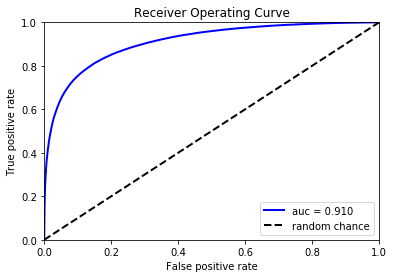

In [13]:
# Plot ROC for Signal ID
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(test_data['labels'][:,1], predict_1[:,1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='b', label='auc = %.3f' % (roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
plt.xlim([0, 1.0])
plt.ylim([0, 1.0])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Receiver Operating Curve')
plt.legend(loc="lower right")
plt.show()
# plt.savefig('plots/roc_image_allVars_sig.png')

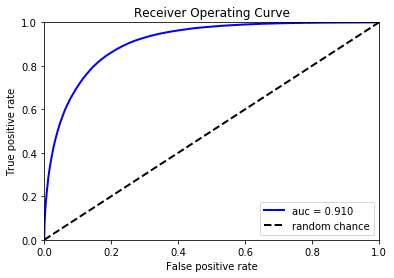

In [14]:
# Plot ROC for Bkg ID
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(test_data['labels'][:,0], predict_1[:,0])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='b', label='auc = %.3f' % (roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
plt.xlim([0, 1.0])
plt.ylim([0, 1.0])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Receiver Operating Curve')
plt.legend(loc="lower right")
plt.show()
# plt.savefig('plots/roc_image_allVars_bkg.png')

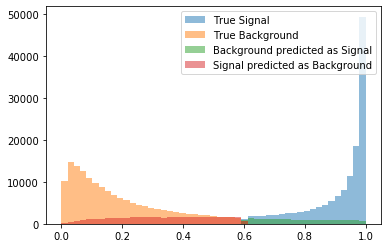

In [15]:
sig_tp = predict_1[(test_data['labels'][:,1]==1) & (predict_1[:,1]>=0.6)][:,1]
bkg_tn = predict_1[(test_data['labels'][:,0]==1) & (predict_1[:,1]<0.6)][:,1]
sig_fp = predict_1[(test_data['labels'][:,0]==1) & (predict_1[:,1]>=0.6)][:,1]
bkg_fn = predict_1[(test_data['labels'][:,1]==1) & (predict_1[:,1]<0.6)][:,1]

bins = np.linspace(0, 1, 50)

plt.hist(sig_tp, bins, alpha=0.5, label='True Signal')
plt.hist(bkg_tn, bins, alpha=0.5, label='True Background')
plt.hist(sig_fp, bins, alpha=0.5, label='Background predicted as Signal')
plt.hist(bkg_fn, bins, alpha=0.5, label='Signal predicted as Background')
plt.legend(loc='best')
plt.show()

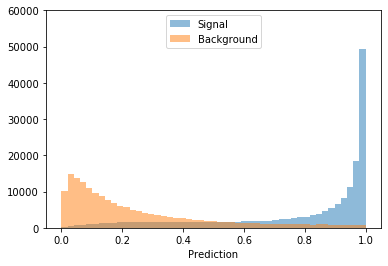

In [16]:
sig = predict_1[(test_data['labels'][:,1]==1)][:,1]
bkg = predict_1[(test_data['labels'][:,0]==1)][:,1]

bins = np.linspace(0, 1, 50)

plt.hist(sig, bins, alpha=0.5, label='Signal')
plt.hist(bkg, bins, alpha=0.5, label='Background')
plt.ylim(0,60000)
plt.legend(loc='upper center')
plt.xlabel('Prediction')
plt.show()

In [ ]:
#first Normed model trained for 32 epochs
#second Normed model trained for

In [ ]:
# matrix = tensorflow.math.confusion_matrix(np.array(list(test_data['labels'].values))[:,0], predict[:,0])

In [ ]:
# with tf.Session():
#    print('Confusion Matrix: \n\n', tf.Tensor.eval(matrix,feed_dict=None, session=None))